In [3]:
import os
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from tqdm.contrib.itertools import product as tqdm_product
from collections import defaultdict

# Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Format the AnnData object

## Basic modifications

In [4]:
# File is in the shared drive
# https://drive.google.com/file/d/1FLSDaiZ3DvNv4Z4yRzjPEKpmK2CkULkf/view?usp=drive_link
adata = sc.read_h5ad("../scrnaseq/run/star_plate/star/mtx_conversions/combined_raw_matrix.h5ad")

# nf-core/scrnaseq adds these columns to the obs dataframe, but they are not useful for us
adata.obs = adata.obs.drop(columns=["fastq_1", "fastq_2"])

# Add column for sample type
adata.obs["sample"] = adata.obs["sample"].str.replace("_raw", "")
adata.obs["sample_type"] = adata.obs["sample"].map(lambda x: "rr_incl" if "RR" in x else "combined" if x.startswith("combined") else "rr_depl")

# Extract the barcode from the cell name
adata.obs["barcode"] = adata.obs.index.str.split("_").str[0]

# Convert the count matrix to int32
adata.layers["count"] = adata.layers["count"].astype("int32")
adata.X = adata.layers["count"]

# By default, the var names are the gene IDs
# Gene names are generally easier to interpret, so we will use the gene names as the var names
# In some cases this will result in duplicate var names, but here this is not a problem
adata.var_names = adata.var["gene_symbol"].str.upper()

# Saving the anndata object fails if the index name also exists as a column
adata.var.index.name = "gene_name"

adata

AnnData object with n_obs × n_vars = 12288 × 79623
    obs: 'sample', 'sample_type', 'barcode'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions'
    layers: 'ambiguous', 'count', 'spliced', 'unspliced'

## Identify the cell types

We were provided with a mapping from the cell position to the cell type.
Thus, we first need to map the barcodes to the positions in the matrix and then map the positions to the cell types.

In [5]:
df_bc_pos = pd.read_csv("../data/reference/plate_position.tsv", sep="\t", index_col=1)
bc_pos = df_bc_pos.to_dict()["Position"]

adata.obs["well_position"] = adata.obs["barcode"].map(bc_pos)

# well_position looks like "A11"
adata.obs["well_row"] = adata.obs["well_position"].str[0]
adata.obs["well_column"] = adata.obs["well_position"].str[1:].astype(int)

# Columns 0-11 are 2CLC, columns 12-23 are mESC
adata.obs["cell_type"] = adata.obs["well_column"].apply(lambda x: "mESC" if x > 11 else "2CLC")

# Set sample 24L007783 to 2CLC
adata.obs.loc[adata.obs["sample"] == "24L007783", "cell_type"] = "2CLC"

# Set sample 24L007784 to mESC
adata.obs.loc[adata.obs["sample"] == "24L007784", "cell_type"] = "mESC"

In [6]:
df_gtf = pd.read_csv("../data/reference/mouse/modified/gtf.gtf", sep="\t", comment="#", header=None)
df_gtf.columns = ["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"]
df_gtf = df_gtf[df_gtf["feature"] == "transcript"]
df_gtf['attribute'] = df_gtf['attribute'].apply(lambda row: dict([[value.strip(r'"') for value in entry.strip().split(' ', 1)] for entry in row.split(';') if entry]))
df_gtf["gene_id"] = df_gtf["attribute"].apply(lambda x: x["gene_id"])
df_gtf["gene_name"] = df_gtf["attribute"].apply(lambda x: x["gene_name"])
df_gtf["gene_type"] = df_gtf["attribute"].apply(lambda x: x["gene_type"])
df_gtf = df_gtf[["gene_id", "gene_name", "gene_type"]]
df_gtf.index = df_gtf["gene_id"]
df_gtf = df_gtf[~df_gtf.index.duplicated(keep='first')]
df_gtf.drop(columns="gene_id", inplace=True)
adata.var["gene_type"] = adata.var["gene_ids"].map(df_gtf["gene_type"]).fillna("transposable_element")
adata.var["gene_type"].value_counts()

gene_type
lncRNA                                32957
protein_coding                        21749
processed_pseudogene                   9329
TEC                                    3220
miRNA                                  2206
unprocessed_pseudogene                 2158
snoRNA                                 1507
snRNA                                  1381
transposable_element                   1226
transcribed_unprocessed_pseudogene      995
transcribed_processed_pseudogene        949
misc_RNA                                562
rRNA                                    360
IG_V_gene                               218
IG_V_pseudogene                         158
TR_V_gene                               144
ERCC-spike-in                            92
TR_J_gene                                70
transcribed_unitary_pseudogene           67
unitary_pseudogene                       59
scaRNA                                   51
TR_V_pseudogene                          34
ribozyme              

In [7]:
adata.raw = adata.copy()

# Quality control

In [8]:
# All human mitochondrial genes start with "mt-"
adata.var["mt"] = adata.var["gene_symbol"].str.startswith("mt-")
adata.var["rRNA"] = adata.var["gene_type"] == "rRNA"
adata.var["lncRNA"] = adata.var["gene_type"] == "lncRNA"

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "rRNA", "lncRNA"], inplace=True, log1p=True, layer="count"
)

In [9]:
# Empty wells
adata = adata[~adata.obs.index.isin(['ACGTTGTA_24L007780_S2_L002_raw', 'GGATGATG_2CLCmesc_6_RR_S14_raw', 'GTGATGTC_2CLCmesc_6_RR_S14_raw'])].copy()

In [10]:
sc.pp.scrublet(adata, batch_key="sample")
adata.obs["predicted_doublet"].value_counts()

predicted_doublet
False    10764
True      1522
Name: count, dtype: int64

## Raw QC plots

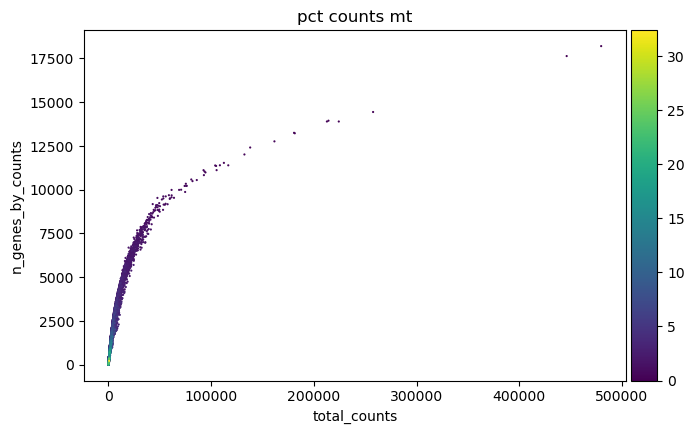

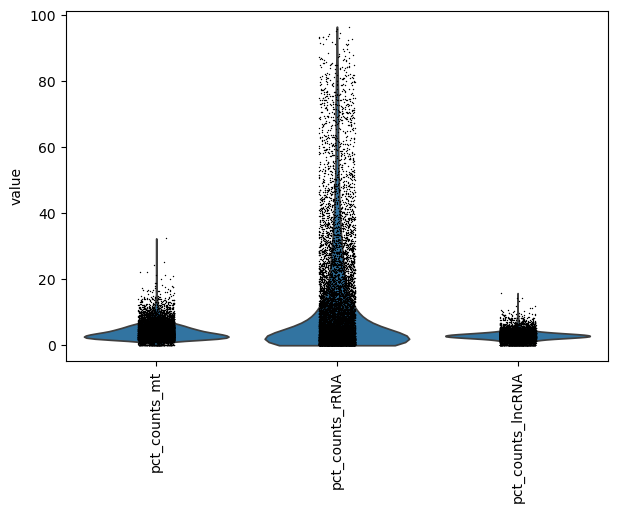

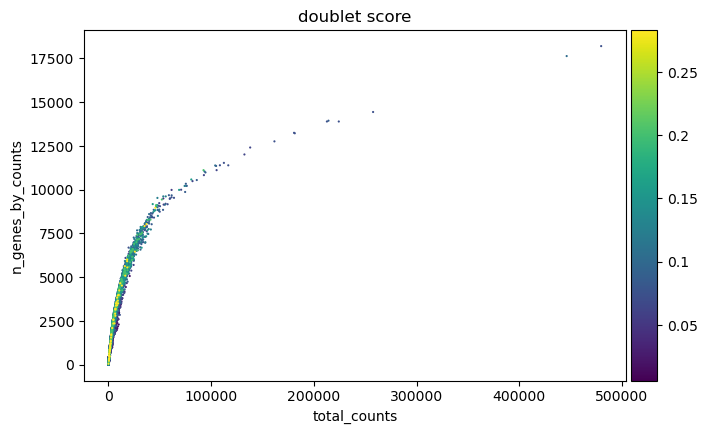

In [11]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sc.pl.violin(adata, ["pct_counts_mt", "pct_counts_rRNA", "pct_counts_lncRNA"], rotation=90)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="doublet_score")

# Well-position heatmaps

In [12]:
metrics = ["n_genes_by_counts", "log1p_n_genes_by_counts", "log1p_total_counts", "total_counts", "pct_counts_mt", "doublet_score"]
outdir = "figures/qc"
os.makedirs(outdir, exist_ok=True)

for sample, metric in tqdm_product(adata.obs["sample"].unique(), metrics + ["pct_counts_rRNA", "pct_counts_lncRNA"]):
    metric_dir = f"{outdir}/{metric}"
    os.makedirs(metric_dir, exist_ok=True)

    sample_data = adata[adata.obs["sample"] == sample, :].copy() #collect the data only for 1 sample
    heatmap_data = sample_data.obs.pivot_table(
        index='well_row',
        columns='well_column',
        values=metric
        )
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt=".1f", cbar_kws={'label': metric})
    plt.title(sample)
    plt.xlabel("Well Column")
    plt.ylabel("Well Row")
    plt.tight_layout()
    
    plt.savefig(f"{metric_dir}/{sample}.png")
    plt.close()

100%|██████████| 256/256 [01:30<00:00,  2.82it/s]


# Overlap between matched samples

In [13]:
sample_matching = pd.read_csv(
    "../data/reference/sample_matching.tsv",
    sep="\t",
    header=None,
    dtype=str
)
sample_matching.columns = ["sample_group", "rr_depl", "rr_incl", "combined", "facs_day"]
sample_matching = sample_matching.melt(value_vars=["rr_depl", "rr_incl", "combined"], id_vars=["sample_group", "facs_day"])
sample_matching.index = sample_matching["value"]
sample_matching.drop(columns=["value", "variable"], inplace=True)

sample_group = sample_matching["sample_group"].to_dict()
sample_facs_day = sample_matching["facs_day"].map({"1": "A", "2": "B"}).to_dict()

In [14]:
adata.obs["sample_group"] = adata.obs["sample"].map(sample_group).astype("category")
adata.obs["facs_day"] = adata.obs["sample"].map(sample_facs_day)
adata.obs["sample_group"].value_counts()

sample_group
003    1152
004    1152
011    1152
016    1152
1      1152
2      1152
3      1152
4      1152
5      1152
6      1150
83      384
84      384
Name: count, dtype: int64

In [15]:
adata_matched = adata[adata.obs["sample_group"].notnull()].copy()
match_types = adata_matched.obs["sample_type"].unique()
metrics_smaller_better = ["pct_counts_mt", "doublet_score"]

for metric, type1, type2 in tqdm_product(metrics, match_types, match_types):
    if type1 == type2 or type1 < type2:
        continue

    smaller_better = metric in metrics_smaller_better
    os.makedirs(f"{outdir}/jaccard/{metric}", exist_ok=True)

    obs_type1 = adata_matched.obs.loc[adata_matched.obs["sample_type"] == type1, [metric, "well_position", "sample_group"]]
    obs_type2 = adata_matched.obs.loc[adata_matched.obs["sample_type"] == type2, [metric, "well_position", "sample_group"]]

    thresholds_jaccard = defaultdict(lambda: defaultdict(float))

    for type1_threshold, type2_threshold in product(
        np.linspace(obs_type1[metric].min(), obs_type1[metric].max(), 15), 
        np.linspace(obs_type2[metric].min(), obs_type2[metric].max(), 15)
        ):
        type1_pass = obs_type1[obs_type1[metric] > type1_threshold] if smaller_better else obs_type1[obs_type1[metric] < type1_threshold]
        type2_pass = obs_type2[obs_type2[metric] > type2_threshold] if smaller_better else obs_type2[obs_type2[metric] < type2_threshold]

        type1_set = set(zip(type1_pass["well_position"], type1_pass["sample_group"]))
        type2_set = set(zip(type2_pass["well_position"], type2_pass["sample_group"]))

        union_size = len(type1_set.union(type2_set))
        jaccard = len(type1_set.intersection(type2_set)) / union_size if union_size > 0 else np.nan
        thresholds_jaccard[type1_threshold][type2_threshold] = jaccard

    df_jaccard = pd.DataFrame(thresholds_jaccard)
    sns.heatmap(df_jaccard, cmap="viridis", annot=False, cbar_kws={'label': "Jaccard Index"})
    plt.xlabel(f"{type2}")
    plt.ylabel(f"{type1}")
    plt.title(f"Jaccard Index for {metric}")
    plt.tight_layout()
    plt.savefig(f"{outdir}/jaccard/{metric}/{type1}_{type2}.png")
    plt.close()

100%|██████████| 54/54 [00:12<00:00,  4.49it/s]


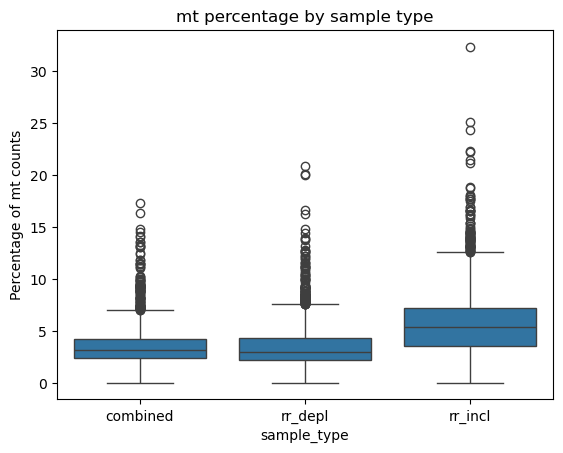

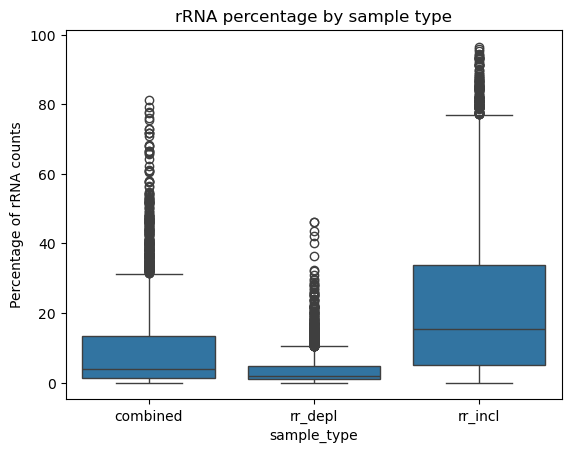

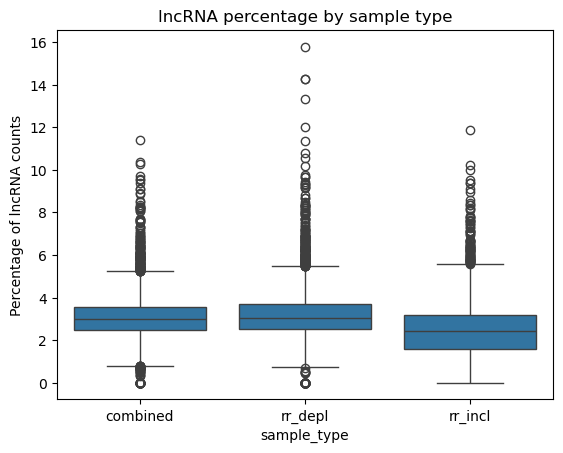

In [16]:
df_matched = adata_matched.obs.copy()
for metric in ["mt", "rRNA", "lncRNA"]:
    sns.boxplot(data=df_matched, x="sample_type", y=f"pct_counts_{metric}")
    plt.ylabel(f"Percentage of {metric} counts")
    plt.title(f"{metric} percentage by sample type")
    plt.show()
    plt.close()

# Visualization of expression in the samples

In [17]:
well_columns = np.sort(adata.obs["well_column"].unique())
well_rows = np.sort(adata.obs["well_row"].unique())
adata_type = ["combined","rr_depl","rr_incl"]

In [18]:
gene_list = ["ZSCAN4A", "ZSCAN4B", "ZSCAN4C", "ZSCAN4D", "ZSCAN4E", "ZSCAN4F", "GFPT1", "GFPT2", "DUXF3", "ZFP352", "EIF1AD10", "SOX2", "NANOG", "MERVL-INT:TE", "MERVL_2A-INT:TE", "TBGFP"]

for type, gene in tqdm_product(adata_type, gene_list):
    os.makedirs(f"{outdir}/genes/{gene}", exist_ok=True)

    adata_gene = adata_matched[adata_matched.obs["sample_type"] == type,:].copy()
    gene_df = pd.DataFrame(columns = well_columns, index = well_rows)

    for well in adata_gene.obs["well_position"].unique():

        well_position_mask = adata_gene.obs["well_position"] == well
        well_column_mask = adata_gene.var_names == gene

        row_indices = np.where(well_position_mask)[0]
        col_indices = np.where(well_column_mask)[0]

        gene_values = adata_gene.X[row_indices, col_indices].flatten()  
        gene_sum = np.sum(gene_values)

        well_row = well[0]
        well_column = int(well[1:])
        gene_df.loc[well_row, well_column] = gene_sum
        
    gene_df = gene_df.fillna(0)
    sns.heatmap(gene_df, cmap="viridis", annot=False, cbar_kws={'label': "Gene expression"})
    plt.xlabel("Well columns")
    plt.ylabel("Well rows")
    plt.title(f"{gene} expression: {type}")
    plt.tight_layout()
    plt.savefig(f"{outdir}/genes/{gene}/{type}_{gene}.png")
    plt.close()

100%|██████████| 48/48 [01:44<00:00,  2.18s/it]


In [19]:
for type in adata_type:
    os.makedirs(f"{outdir}/genes/ERCC-SPIKE-IN", exist_ok=True)

    adata_gene = adata_matched[adata_matched.obs["sample_type"] == type,adata_matched.var["gene_type"] == "ERCC-spike-in"].copy()
    gene_df = pd.DataFrame(columns = well_columns, index = well_rows)

    for well in adata_gene.obs["well_position"].unique():

        well_position_mask = adata_gene.obs["well_position"] == well
        #well_column_mask = adata_gene.var["gene_type"] == "ERCC-spike-in"

        row_indices = np.where(well_position_mask)[0]
        #col_indices = np.where(well_column_mask)[0]

        gene_values = adata_gene.X[row_indices, :].toarray().flatten()  
        gene_sum = np.sum(gene_values)

        well_row = well[0]
        well_column = int(well[1:])
        gene_df.loc[well_row, well_column] = gene_sum
        
    gene_df = gene_df.fillna(0)
    sns.heatmap(gene_df, cmap="viridis", annot=False, cbar_kws={'label': "Gene expression"})
    plt.xlabel("Well columns")
    plt.ylabel("Well rows")
    plt.title(f"ERCC-SPIKE-IN expression: {type}")
    plt.tight_layout()
    plt.savefig(f"{outdir}/genes/ERCC-SPIKE-IN/{type}_ERCC-SPIKE-IN.png")
    plt.close()

In [20]:
for type, sample in tqdm_product(adata_type, adata.obs["sample"].unique()):
    os.makedirs(f"{outdir}/genes/{type}", exist_ok=True)

    adata_samp = adata_matched[adata_matched.obs["sample_type"] == type,:]
    adata_diff = adata_samp[adata_samp.obs["sample"] == sample, :]
    gene_df = pd.DataFrame(columns = well_columns, index = well_rows)

    for well in adata_diff.obs["well_position"].unique():

        well_position_mask = adata_diff.obs["well_position"] == well

        row_indices = np.where(well_position_mask)[0]

        gene_values = adata_diff.X[row_indices,:].toarray().flatten()  
        gene_sum = np.sum(gene_values)

        well_row = well[0]
        well_column = int(well[1:])
        gene_df.loc[well_row, well_column] = gene_sum
        
    gene_df = gene_df.fillna(0)
    sns.heatmap(gene_df, cmap="viridis", annot=False, cbar_kws={'label': "Gene expression"})
    plt.xlabel("Well columns")
    plt.ylabel("Well rows")
    plt.title(f"Gene expression:{type}_{sample}")
    plt.tight_layout()
    plt.savefig(f"{outdir}/genes/{type}/{sample}.png")
    plt.close()

100%|██████████| 96/96 [00:44<00:00,  2.18it/s]


## Filtering

Thresholds were estimated based on the raw QC plots.
Can be adjusted if needed.

<Axes: title={'center': 'Histogram of log1p total counts for rRNA genes'}, ylabel='Frequency'>

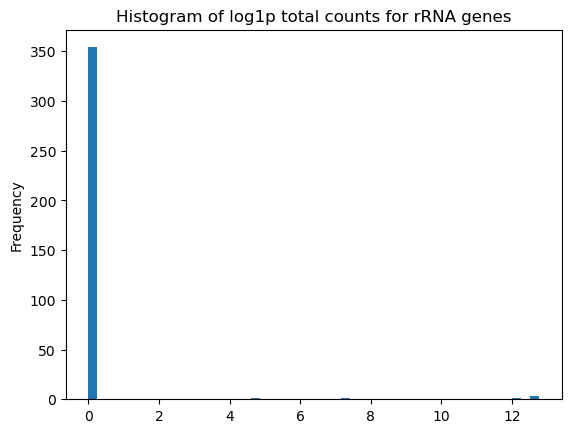

In [21]:
adata_rrna = adata[:, adata.var["gene_type"] == "rRNA"].copy()
adata_rrna.var["log1p_total_counts"].plot.hist(bins=50, title="Histogram of log1p total counts for rRNA genes")

In [22]:
sc.pp.filter_genes(adata, min_cells=3)
adata.var["gene_type"].value_counts()

gene_type
protein_coding                        16144
lncRNA                                 8397
processed_pseudogene                   1809
TEC                                    1492
transposable_element                   1013
transcribed_processed_pseudogene        161
unprocessed_pseudogene                  118
snoRNA                                   79
ERCC-spike-in                            68
misc_RNA                                 50
transcribed_unprocessed_pseudogene       49
snRNA                                    35
scaRNA                                   11
rRNA                                      6
transcribed_unitary_pseudogene            6
unitary_pseudogene                        5
ribozyme                                  4
IG_V_gene                                 2
Mt_rRNA                                   2
miRNA                                     2
TR_C_gene                                 2
TR_V_pseudogene                           1
TR_V_gene             

In [23]:
adata.n_obs

12286

In [24]:
adata = adata[adata.obs["pct_counts_mt"] < 12, :].copy()
adata.n_obs

12140

In [25]:
adata = adata[adata.obs["n_genes_by_counts"] > 200, :].copy()
adata.n_obs

9839

In [26]:
#filtering doublets withdifferent threshold for RR and non-RR
adata = adata[adata.obs["doublet_score"] < 0.17, :].copy()
adata.n_obs

9565

In [27]:
#filtering wrong columns and wells
adata = adata[~adata.obs["well_column"].isin([21, 24])]
adata = adata[~adata.obs["well_position"].isin(["P22", "P23"]),:]
adata.n_obs

9027

## Filtered QC plots

/nfs/home/students/n.trummer/.conda/envs/single-cell/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


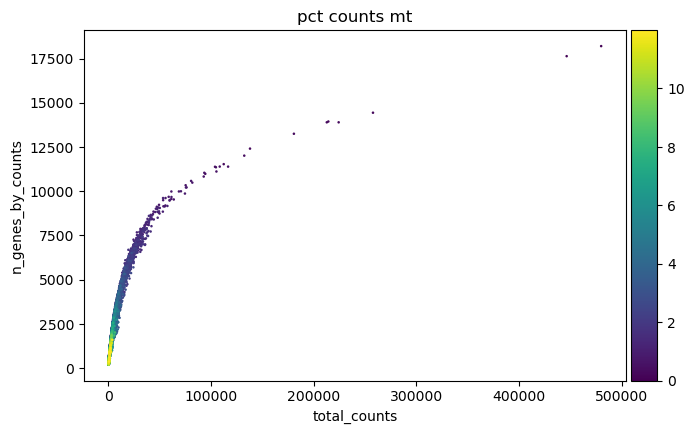

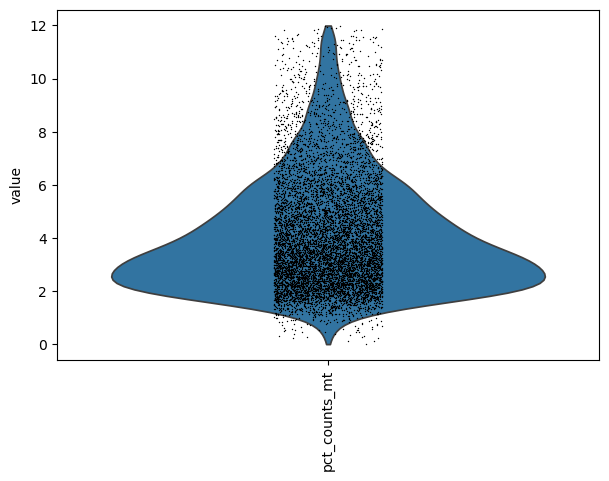

In [28]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sc.pl.violin(adata, "pct_counts_mt", rotation=90)

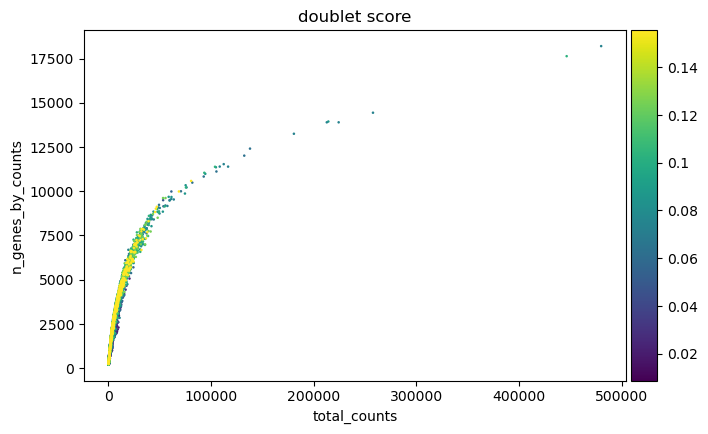

In [29]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="doublet_score")

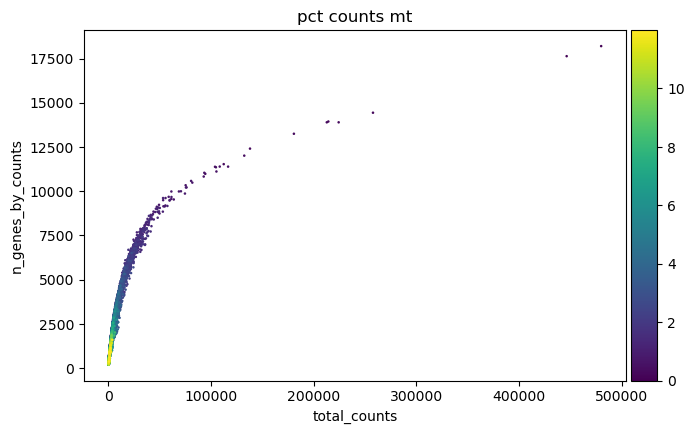

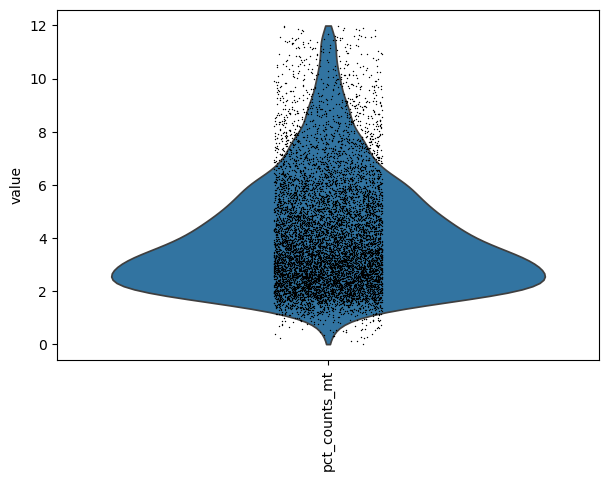

In [30]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sc.pl.violin(adata, "pct_counts_mt", rotation=90)

# Normalization

These steps update adata.X

In [31]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [ ]:
# This resembles the preprocessing in
# https://github.com/theislab/scib/blob/023c4e81f49156503e7e85ecc1d2d8405401eb1c/scib/resources/convert_genes.py#L59-L91


# Cell cycle scoring

In [32]:
adata_scaled = adata.copy()
sc.pp.scale(adata_scaled)

In [34]:
adata_scaled.var

,gene_ids,feature_types,gene_symbol,gene_versions,gene_type,mt,rRNA,lncRNA,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,mean,std
gene_name,,,,,,,,,,,,,,,,,
ENSMUSG00000144196,ENSMUSG00000144196.1,Gene Expression,ENSMUSG00000144196,ENSMUSG00000144196.1,lncRNA,False,False,True,135,0.012451,0.012374,98.901367,153,5.036953,135,0.009105,0.091016
MERVL-INT:TE,MERVL-int,Gene Expression,MERVL-int:TE,MERVL-int,transposable_element,False,False,False,9841,15.649089,2.812355,19.913737,192296,12.166796,9841,2.121485,1.489765
MT2_MM:TE,MT2_Mm,Gene Expression,MT2_Mm:TE,MT2_Mm,transposable_element,False,False,False,7632,7.264486,2.111968,37.890625,89266,11.399387,7632,1.252946,1.336624
RLTR51A_MM:TE,RLTR51A_Mm,Gene Expression,RLTR51A_Mm:TE,RLTR51A_Mm,transposable_element,False,False,False,63,0.005452,0.005438,99.487305,67,4.219508,63,0.002270,0.037108
B3A:TE,B3A,Gene Expression,B3A:TE,B3A,transposable_element,False,False,False,4619,1.165771,0.772777,62.410482,14325,9.569831,4619,0.362500,0.488479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERCC-00163,ERCC-00163,Gene Expression,ERCC-00163,ERCC-00163,ERCC-spike-in,False,False,False,49,0.003988,0.003980,99.601237,49,3.912023,49,0.002150,0.035846
ERCC-00165,ERCC-00165,Gene Expression,ERCC-00165,ERCC-00165,ERCC-spike-in,False,False,False,276,0.023844,0.023565,97.753906,293,5.683580,276,0.013576,0.111206
ERCC-00170,ERCC-00170,Gene Expression,ERCC-00170,ERCC-00170,ERCC-spike-in,False,False,False,100,0.008382,0.008347,99.186198,103,4.644391,100,0.004533,0.060250


In [38]:
gene_names = pd.read_csv("regev_lab_cell_cycle_genes.txt", header=None)[0].str.upper().to_list()
genes_s = gene_names[:43]
genes_g2m = gene_names[43:]

In [40]:
sc.tl.score_genes_cell_cycle(adata_scaled, genes_s, genes_g2m)
adata_scaled.obs[['S_score', 'G2M_score', 'phase']].head()

,S_score,G2M_score,phase
AAACAGGC_2CLCmesc_004_RR_S4_raw,0.567336,-0.045617,S
AAAGCGGA_2CLCmesc_004_RR_S4_raw,0.255580,-0.048301,S
AAAGGCTG_2CLCmesc_004_RR_S4_raw,-0.014881,-0.031753,G1
AACACGCA_2CLCmesc_004_RR_S4_raw,0.207961,-0.055456,S
AACATGGG_2CLCmesc_004_RR_S4_raw,0.064732,0.010733,S


In [41]:
adata.obs['S_score'] = adata_scaled.obs['S_score']
adata.obs['G2M_score'] = adata_scaled.obs['G2M_score']
adata.obs['phase'] = adata_scaled.obs['phase']

# Finalize and save

In [42]:
# Make a copy of the log-transformed data
# It is always good to store alternative representations of count data with explicit names
# It is easy to forget what adata.X contains at a later point
adata.layers["log1p"] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 9027 × 29459
    obs: 'sample', 'sample_type', 'barcode', 'well_position', 'well_row', 'well_column', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'total_counts_lncRNA', 'log1p_total_counts_lncRNA', 'pct_counts_lncRNA', 'n_genes', 'doublet_score', 'predicted_doublet', 'sample_group', 'facs_day', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions', 'gene_type', 'mt', 'rRNA', 'lncRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet', 'log1p'
    layers: 'ambiguous', 'count', 'spliced', 'unspliced', 'log1

In [43]:
adata.write_h5ad("1_qc.h5ad")